In [44]:
### Project Summary

# This project uses U.S. national crime data (1960–2014) to detect "anomaly" years based on year-over-year deviations in key crime categories. By 
# normalizing for population and applying rolling Z-score thresholds, I identified years where specific crimes spiked or dropped in statistically 
# unusual ways. These anomalies are then tied to major historical events or societal shifts. 

# The final output includes a ranked list of high-anomaly years and crime types most associated with instability—offering a framework that 
# could be used for historical insight or early-warning monitoring.


In [45]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mahmoudshogaa/us-crime-rates-1960-2014")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\saries\.cache\kagglehub\datasets\mahmoudshogaa\us-crime-rates-1960-2014\versions\1


In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import STL

In [47]:
crime_df = pd.read_csv(f"{path}/US_Crime_Rates_1960_2014.csv")

In [48]:
crime_df.head()
crime_df.info()
crime_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55 entries, 0 to 54
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   Year                55 non-null     int64
 1   Population          55 non-null     int64
 2   Total               55 non-null     int64
 3   Violent             55 non-null     int64
 4   Property            55 non-null     int64
 5   Murder              55 non-null     int64
 6   Forcible_Rape       55 non-null     int64
 7   Robbery             55 non-null     int64
 8   Aggravated_assault  55 non-null     int64
 9   Burglary            55 non-null     int64
 10  Larceny_Theft       55 non-null     int64
 11  Vehicle_Theft       55 non-null     int64
dtypes: int64(12)
memory usage: 5.3 KB


,Year,Population,Total,Violent,Property,Murder,Forcible_Rape,Robbery,Aggravated_assault,Burglary,Larceny_Theft,Vehicle_Theft
count,55.00000,5.500000e+01,5.500000e+01,5.500000e+01,5.500000e+01,55.000000,55.000000,55.000000,5.500000e+01,5.500000e+01,5.500000e+01,5.500000e+01
mean,1987.00000,2.461556e+08,1.060315e+07,1.188806e+06,9.412499e+06,17317.236364,72714.800000,416449.890909,6.811818e+05,2.424017e+06,5.959947e+06,1.028614e+06
std,16.02082,4.166216e+07,3.175931e+06,4.597107e+05,2.738512e+06,4267.442664,28278.006893,150506.403782,2.960255e+05,7.259004e+05,1.846401e+06,3.455693e+05
min,1960.00000,1.793232e+08,3.384200e+06,2.884600e+05,3.095700e+06,8530.000000,17190.000000,106670.000000,1.543200e+05,9.121000e+05,1.855400e+06,3.282000e+05
25%,1973.50000,2.106215e+08,9.096958e+06,9.253150e+05,8.060014e+06,14819.000000,53400.000000,354911.500000,4.384300e+05,2.105336e+06,4.843350e+06,7.896260e+05
50%,1987.00000,2.422829e+08,1.140151e+07,1.322390e+06,1.018259e+07,17030.000000,84230.000000,423557.000000,7.412910e+05,2.329950e+06,6.591900e+06,1.032200e+06
75%,2000.50000,2.833697e+08,1.308449e+07,1.432762e+06,1.160509e+07,20561.500000,92930.000000,512137.000000,9.002150e+05,3.073600e+06,7.168450e+06,1.239302e+06
max,2014.00000,3.188571e+08,1.487290e+07,1.932270e+06,1.296110e+07,24700.000000,109060.000000,687730.000000,1.135610e+06,3.795200e+06,8.142200e+06,1.661700e+06


In [49]:
crime_df.info()
crime_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55 entries, 0 to 54
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   Year                55 non-null     int64
 1   Population          55 non-null     int64
 2   Total               55 non-null     int64
 3   Violent             55 non-null     int64
 4   Property            55 non-null     int64
 5   Murder              55 non-null     int64
 6   Forcible_Rape       55 non-null     int64
 7   Robbery             55 non-null     int64
 8   Aggravated_assault  55 non-null     int64
 9   Burglary            55 non-null     int64
 10  Larceny_Theft       55 non-null     int64
 11  Vehicle_Theft       55 non-null     int64
dtypes: int64(12)
memory usage: 5.3 KB


,Year,Population,Total,Violent,Property,Murder,Forcible_Rape,Robbery,Aggravated_assault,Burglary,Larceny_Theft,Vehicle_Theft
count,55.00000,5.500000e+01,5.500000e+01,5.500000e+01,5.500000e+01,55.000000,55.000000,55.000000,5.500000e+01,5.500000e+01,5.500000e+01,5.500000e+01
mean,1987.00000,2.461556e+08,1.060315e+07,1.188806e+06,9.412499e+06,17317.236364,72714.800000,416449.890909,6.811818e+05,2.424017e+06,5.959947e+06,1.028614e+06
std,16.02082,4.166216e+07,3.175931e+06,4.597107e+05,2.738512e+06,4267.442664,28278.006893,150506.403782,2.960255e+05,7.259004e+05,1.846401e+06,3.455693e+05
min,1960.00000,1.793232e+08,3.384200e+06,2.884600e+05,3.095700e+06,8530.000000,17190.000000,106670.000000,1.543200e+05,9.121000e+05,1.855400e+06,3.282000e+05
25%,1973.50000,2.106215e+08,9.096958e+06,9.253150e+05,8.060014e+06,14819.000000,53400.000000,354911.500000,4.384300e+05,2.105336e+06,4.843350e+06,7.896260e+05
50%,1987.00000,2.422829e+08,1.140151e+07,1.322390e+06,1.018259e+07,17030.000000,84230.000000,423557.000000,7.412910e+05,2.329950e+06,6.591900e+06,1.032200e+06
75%,2000.50000,2.833697e+08,1.308449e+07,1.432762e+06,1.160509e+07,20561.500000,92930.000000,512137.000000,9.002150e+05,3.073600e+06,7.168450e+06,1.239302e+06
max,2014.00000,3.188571e+08,1.487290e+07,1.932270e+06,1.296110e+07,24700.000000,109060.000000,687730.000000,1.135610e+06,3.795200e+06,8.142200e+06,1.661700e+06


In [50]:
crime_df.dtypes #Making sure all of our columns are integers so they can be used in our model

Year                  int64
Population            int64
Total                 int64
Violent               int64
Property              int64
Murder                int64
Forcible_Rape         int64
Robbery               int64
Aggravated_assault    int64
Burglary              int64
Larceny_Theft         int64
Vehicle_Theft         int64
dtype: object

In [51]:
crime_df.duplicated().sum() #Checking for any duplicate rows

np.int64(0)

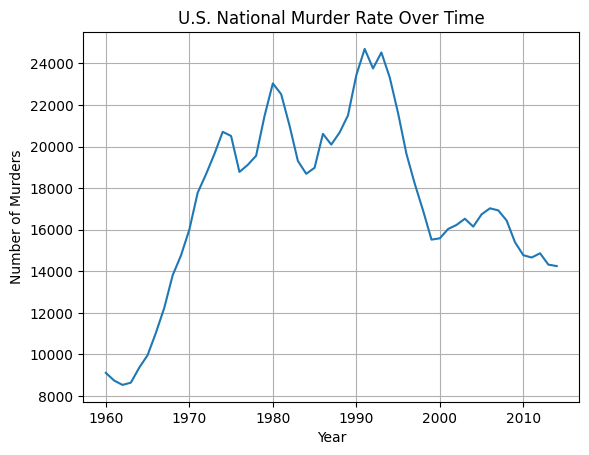

In [52]:
plt.plot(crime_df['Year'], crime_df['Murder'])
plt.title("U.S. National Murder Rate Over Time")
plt.xlabel("Year")
plt.ylabel("Number of Murders")
plt.grid(True)
plt.show()

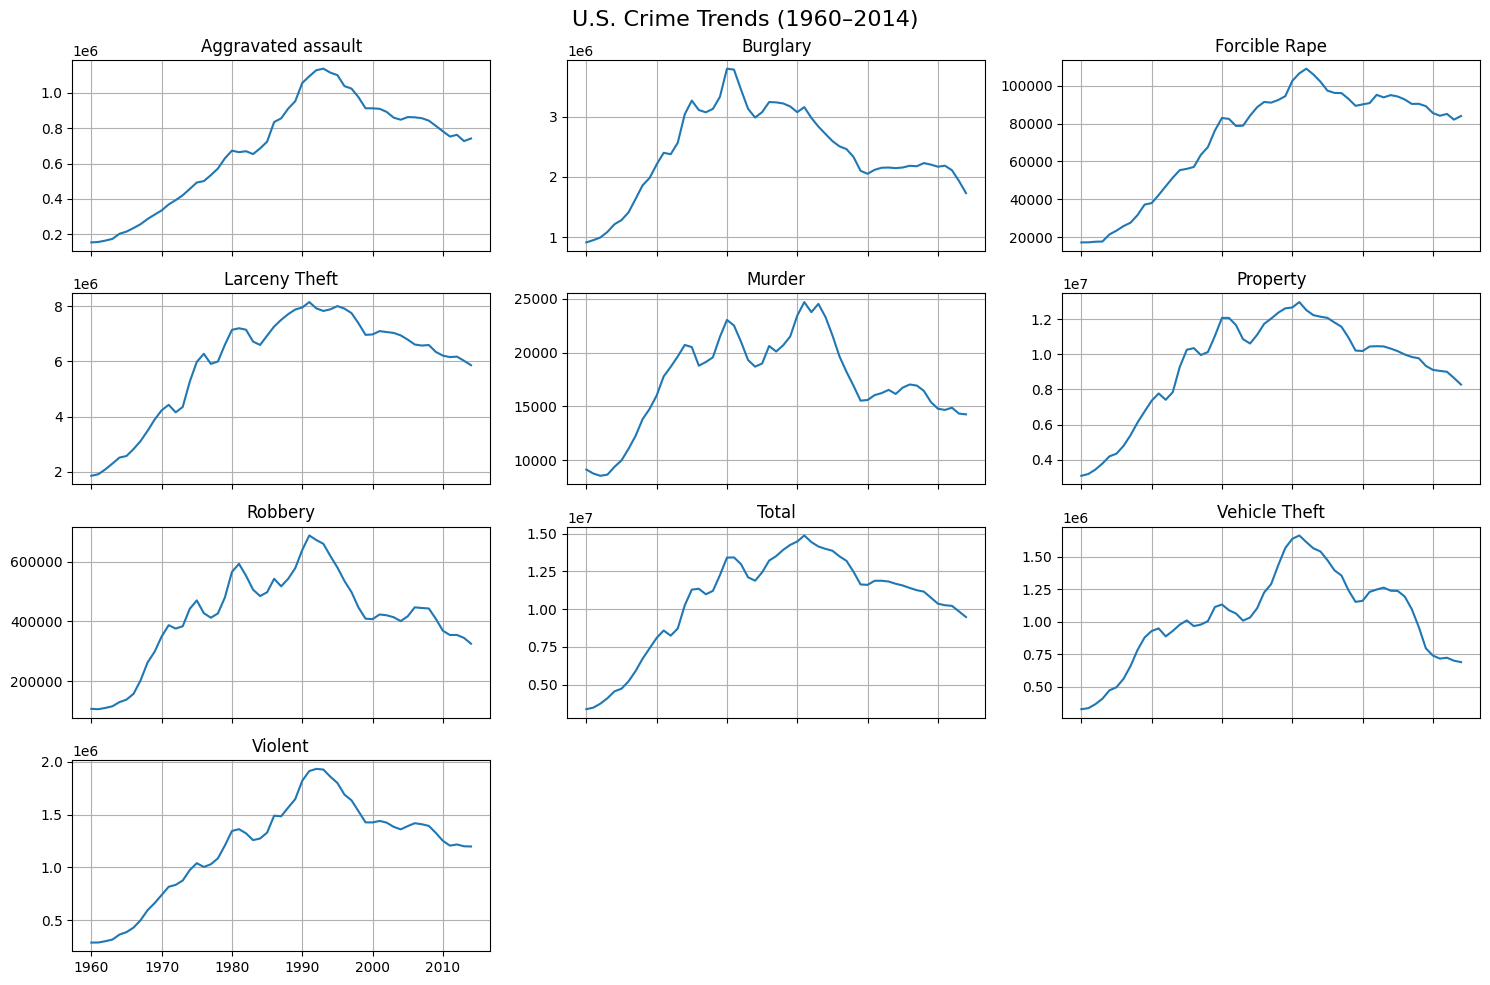

In [53]:
# Excluding year and population as those are going to be constant here
crime_columns = crime_df.columns.difference(['Year', 'Population'])

# This sets up our grid down below to be 4x3
n_cols = 3
n_rows = int(np.ceil(len(crime_columns) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10), sharex=True)
axes = axes.flatten()

# Plotting + Looping through each variable
for i, col in enumerate(crime_columns):
    axes[i].plot(crime_df['Year'], crime_df[col])
    axes[i].set_title(col.replace('_', ' '))
    axes[i].grid(True)

# Hiding the other two spots on our 4x3 plot that won't be filled in here
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

fig.suptitle('U.S. Crime Trends (1960–2014)', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()

#Below plots mainly show a gradual increase in crime and then around the 1990s all of them peaked and then slowly tapered off.

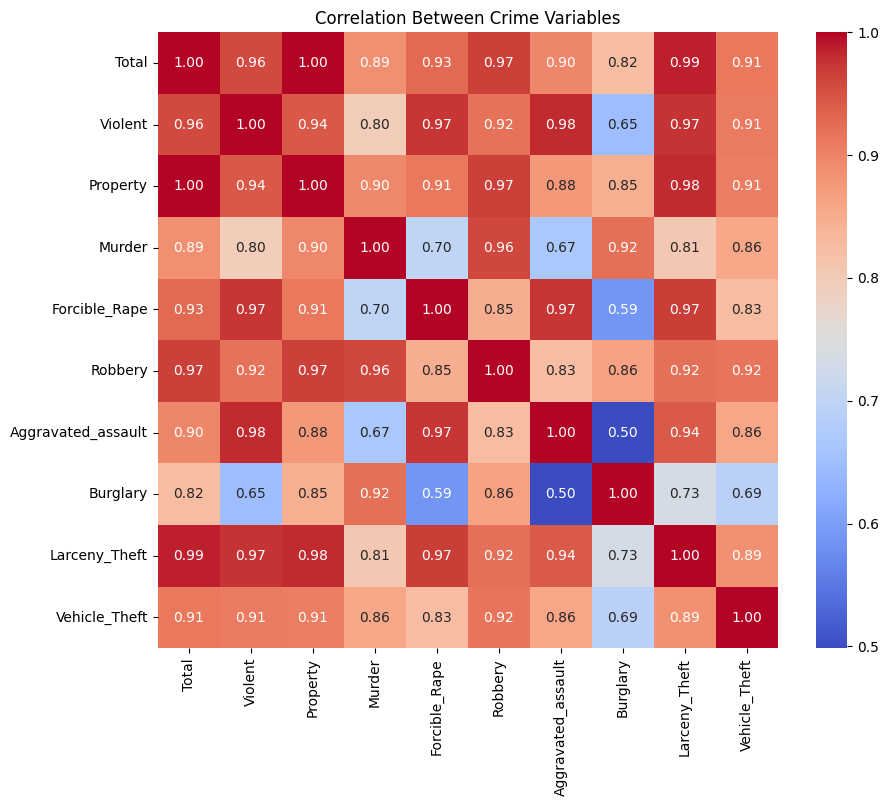

In [54]:
#Checking for multicollinearity between variables
corr = crime_df.drop(columns=['Year', 'Population']).corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Between Crime Variables")
plt.show()

# IMPORTANT NOTE : I'm checking for multicollinearity because I have a suspicion that many crime variables are strongly correlated, 
# especially those that roll up into total crime rates. HOwever, ince I chose an unsupervised anomaly detection approach that analyzes each time series 
# independently, I don't need to remove or transform these variables given this information.

In [55]:
crime_cols = crime_df.columns.difference(['Year', 'Population'])
for col in crime_cols:
    crime_df[f"{col}_per100k"] = (crime_df[col] / crime_df['Population']) * 100000

In [56]:
crime_df['Murder_roll_mean'] = crime_df['Murder_per100k'].rolling(window=5).mean()
crime_df['Murder_roll_std'] = crime_df['Murder_per100k'].rolling(window=5).std()

crime_df['Murder_zscore'] = (crime_df['Murder_per100k'] - crime_df['Murder_roll_mean']) / crime_df['Murder_roll_std']

# Flag anomalies
crime_df['Murder_anomaly'] = crime_df['Murder_zscore'].abs() > 2


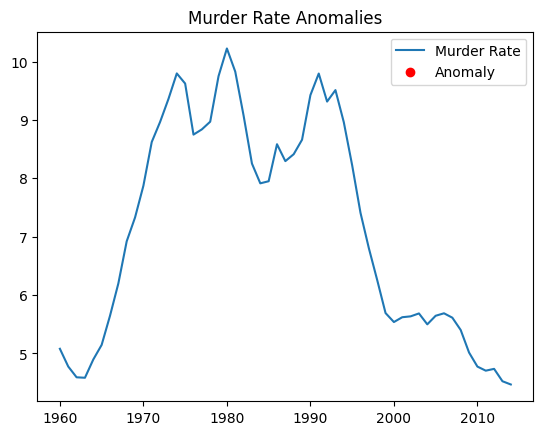

In [57]:
plt.plot(crime_df['Year'], crime_df['Murder_per100k'], label='Murder Rate')
plt.scatter(crime_df['Year'][crime_df['Murder_anomaly']],
            crime_df['Murder_per100k'][crime_df['Murder_anomaly']],
            color='red', label='Anomaly')
plt.legend()
plt.title("Murder Rate Anomalies")
plt.show()

In [58]:
for col in crime_cols:
    base = f"{col}_per100k"
    crime_df[f"{col}_roll_mean"] = crime_df[base].rolling(window=5).mean()
    crime_df[f"{col}_roll_std"] = crime_df[base].rolling(window=5).std()
    crime_df[f"{col}_zscore"] = (crime_df[base] - crime_df[f"{col}_roll_mean"]) / crime_df[f"{col}_roll_std"]
    crime_df[f"{col}_anomaly"] = crime_df[f"{col}_zscore"].abs() > 1.5


In [59]:
anomaly_flags = [col for col in crime_df.columns if col.endswith('_anomaly')]
crime_df['anomaly_score'] = crime_df[anomaly_flags].sum(axis=1)

In [60]:
top_anomalous_years = crime_df[['Year', 'anomaly_score']].sort_values(by='anomaly_score', ascending=False)
print(top_anomalous_years.head())

    Year  anomaly_score
4   1964              6
14  1974              5
30  1990              5
44  2004              4
49  2009              4


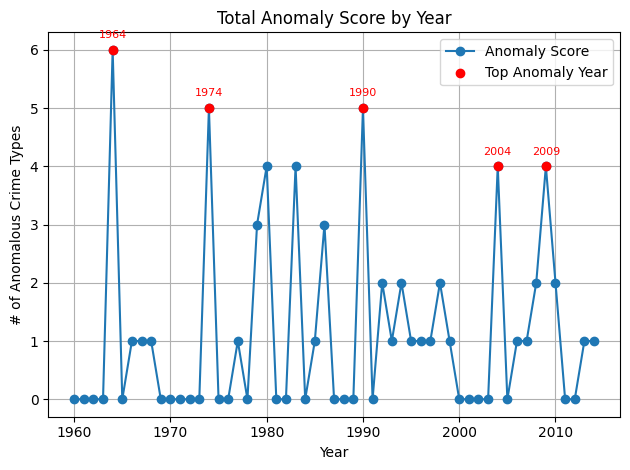

In [68]:
top_years = top_anomalous_years['Year'].head(5).tolist()  

plt.plot(crime_df['Year'], crime_df['anomaly_score'], label='Anomaly Score', marker='o')
plt.scatter(crime_df['Year'][crime_df['Year'].isin(top_years)],
            crime_df['anomaly_score'][crime_df['Year'].isin(top_years)],
            color='red', label='Top Anomaly Year', zorder=5)

# Annotate top years
for year, score in zip(crime_df['Year'], crime_df['anomaly_score']):
    if year in top_years:
        plt.annotate(str(year), xy=(year, score + 0.2), ha='center', fontsize=8, color='red')

plt.title("Total Anomaly Score by Year")
plt.xlabel("Year")
plt.ylabel("# of Anomalous Crime Types")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [62]:
# The red-labeled years represent major spikes in overall crime anomalies. Each of these years aligns with significant societal or policy shifts—such 
# as civil rights tensions (1964), post-Vietnam war shifts (1974), peak violent crime era (1990), and post-9/11 security and economic downfalls 
# (2004 & 2009). The STL plots below help break down these patterns into trend, seasonality, and residual signals.


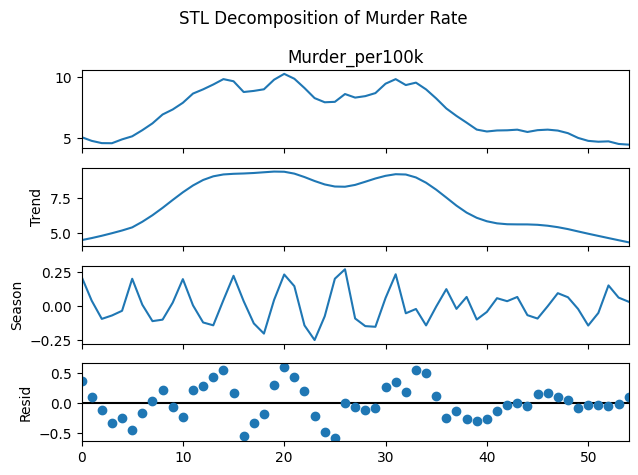

In [63]:
stl = STL(crime_df['Murder_per100k'], period=5)
res = stl.fit()
res.plot()
plt.suptitle("STL Decomposition of Murder Rate")
plt.tight_layout()
plt.show()

In [64]:
# This STL decomposition breaks the murder rate down into three components: trend, seasonality, and residuals.

# The trend line confirms what’s already visible in the raw data (a steady rise in the murder rate through the late 1980s and a 
# long-term decline after the early 1990s). The seasonal component doesn’t show any meaningful yearly pattern, which makes sense since murder rates 
# at the national level probably aren’t tied to any seasonal cycles. 

# The residuals are what’s left after removing both the trend and seasonality (this is where true short-term spikes show up). 
# These residual spikes line up with the years I already flagged using rolling z-score anomaly detection, which helps validate that the 
# anomalies were not just part of the normal trend.


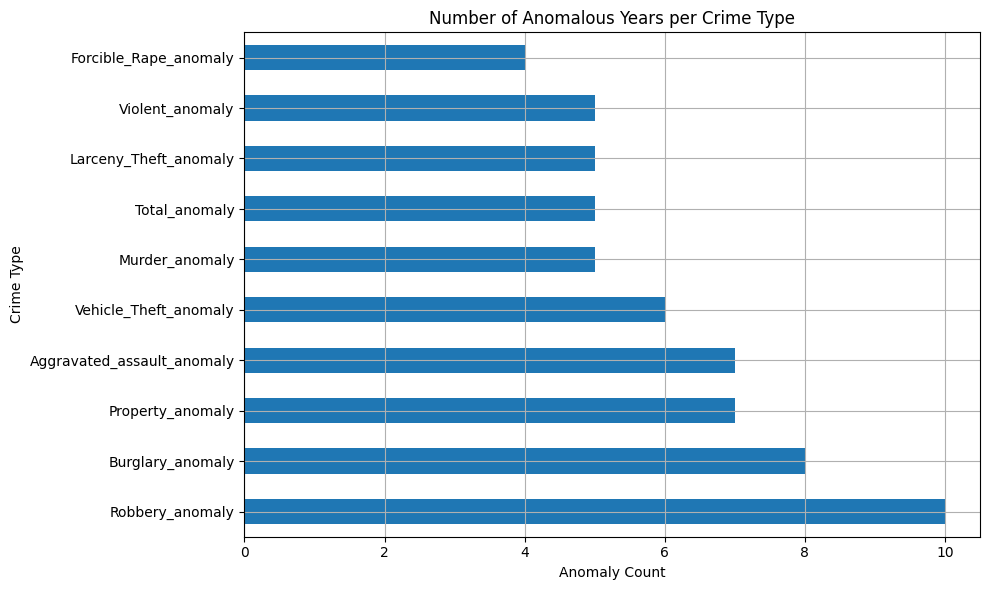

In [65]:
summary = crime_df[[col for col in crime_df.columns if col.endswith('_anomaly')]].sum().sort_values(ascending=False)

summary.plot(kind='barh', figsize=(10, 6))
plt.title("Number of Anomalous Years per Crime Type")
plt.xlabel("Anomaly Count")
plt.ylabel("Crime Type")
plt.grid(True)
plt.tight_layout()
plt.show()

In [66]:
# Over the period from 1960 to 2014, Robbery and Burglary were the most volatile and anomalous crime types in the U.S., each having abnormal behavior 
# in 8 and 10 separate years respectively. In contrast, categories like Forcible Rape and Violent Crime had far fewer unusual years, which suggests
# their trends are more stable over time. This is likely due to more stable long-term patterns or stronger correlation with broader social trends, such
# as public awareness or crime reporting standards, as opposed to isolated events.

In [67]:
### Final Takeaways

# - Robbery and Burglary were the most volatile crime types, with anomalies in 8–10 years.
# - Anomalous years strongly aligned with historical turning points, confirming the usefulness of statistical trend-based monitoring.
# - This unsupervised approach gives clear and actionable insights that could actually help federal or state agencies spot unusual crime patterns and 
#   and make better decisions.
